# Investigate custom `nn.Module` 
Instead of defining it through a `Sequential` of nn built-ins.

### Setup

In [32]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)
df.head(2)

,fn,digit_class,scalar_top,scalar_bottom,scalar_pxsum,point_topleft_x,point_topleft_y,point_center_x,point_center_y
0,/train/3/7.png,3,5,25,35867,11,5,15,14
1,/train/3/7030.png,3,4,24,29717,9,4,14,13


In [4]:
y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                )

db_1_topleft = copyroot.deepcopy(db)
db_1_center  = copyroot.deepcopy(db)
db_2         = copyroot.deepcopy(db)

def set_get_y(db, cr):
    db.get_y = cr
    db.getters[db.n_inp:] = L(db.get_y)

set_get_y( db_1_topleft, ColReader(y_names[:2]) )
set_get_y( db_1_center,  ColReader(y_names[2:]) )
set_get_y( db_2,         ColReader(y_names) )

dl_1_topleft = db_1_topleft.dataloaders(df)
dl_1_center  = db_1_center.dataloaders(df)
dl_2         = db_2.dataloaders(df)

### Build Custom Arch Old Way

In [5]:
# remake a datablock with BW-style images

y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(y_names[2:]),
                  )

dls = dblock.dataloaders(df)

x, y = dls.one_batch()

x.shape

torch.Size([64, 1, 28, 28])

In [6]:
x_2 = x[:2]
x_2.shape

torch.Size([2, 1, 28, 28])

In [7]:
net3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )


out_net3 = net3(x_2)
out_net3.shape

torch.Size([2, 2])

##### Investigate the Object it represents in pytorch

In [14]:
type(net3)

torch.nn.modules.container.Sequential

In [25]:
p = list(net3.parameters())
[_p.shape for _p in p]

In [27]:
net3

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=28, bias=True)
  (2): Linear(in_features=28, out_features=2, bias=False)
  (3): SigmoidRange(low=-1.0, high=1)
)

### Fit Old-Style Arch

In [8]:
learn_net3 = Learner(dls, net3, loss_func=MSELossFlat(), )

In [9]:
learn_net3.fit(1)

epoch,train_loss,valid_loss,time
0,0.009836,0.006594,00:01


In [10]:
preds = learn_net3.get_preds()

##### Fit some more, it gets even better

In [11]:
learn_net3.fit(5)

epoch,train_loss,valid_loss,time
0,0.005101,0.004079,00:01
1,0.003927,0.003646,00:01
2,0.003329,0.002638,00:01
3,0.002881,0.002590,00:01
4,0.002570,0.002472,00:01


In [12]:
def pva_plot(actuals, predcits, title=''):
    plt.scatter(actuals, predicts, alpha=0.4)
    y0, y1 = plt.ylim()
    x0, x1 = plt.xlim()
    full_area = [min(x0, y0), max(x1, y1)]
    plt.plot(full_area, full_area, linestyle='--')
    plt.xlabel('Actual'); plt.ylabel('Predicted');
    plt.title(f'{title} - Predicted vs Actual');

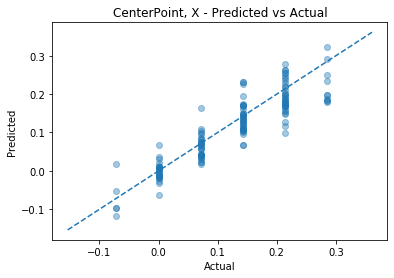

In [13]:
preds = learn_net3.get_preds()
actuals =  preds[1].view(-1,2)[:,0]
predicts = preds[0][:,0]

pva_plot(actuals, predicts, 'CenterPoint, X')

### Build New Arch style

In [71]:
class MyCustomNet3(torch.nn.Module):
    def __init__(self, ):
        super(MyCustomNet3, self).__init__()
        self.flat    = nn.Flatten()
        self.linear1 = nn.Linear(in_features=784, out_features=28)
        self.linear2 = nn.Linear(in_features=28, out_features=2, bias=False)
        self.sig     = SigmoidRange(-1., 1)
    
    def forward(self, x):
        l0 = self.flat(x)
        l1 = self.linear1(l0)
        l2 = self.linear2(l1)
        y =  self.sig(l2)
        return y

##### Investigate its object's properties

In [72]:
mcnet3 = MyCustomNet3()

In [73]:
mcnet3

MyCustomNet3(
  (flat): Flatten()
  (linear1): Linear(in_features=784, out_features=28, bias=True)
  (linear2): Linear(in_features=28, out_features=2, bias=False)
  (sig): SigmoidRange(low=-1.0, high=1)
)

In [74]:
mcnet3(x_2)

tensor([[-0.0636, -0.0533],
        [-0.0933,  0.0346]], grad_fn=<AddBackward0>)

In [75]:
type(mcnet3)

__main__.MyCustomNet3

In [76]:
x_2.shape

torch.Size([2, 1, 28, 28])

In [77]:
mcp = list(mcnet3.parameters())

In [54]:
net3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )


out_net3 = net3(x_2)
out_net3.shape

torch.Size([2, 2])

In [79]:
[_p.shape for _p in net3.parameters()]

[torch.Size([28, 784]), torch.Size([28]), torch.Size([2, 28])]

### Fit New Arch

In [80]:
learn_net3 = Learner(dls, net3, loss_func=MSELossFlat(), )

In [83]:
learn_net3.fit(5)

epoch,train_loss,valid_loss,time
0,0.004283,0.003400,00:01
1,0.003385,0.002821,00:01
2,0.002883,0.003073,00:01
3,0.002582,0.002644,00:01
4,0.002345,0.002491,00:02


### Experiment with new arch elements

In [86]:
x_2.shape

torch.Size([2, 1, 28, 28])

In [87]:
myflat = nn.Flatten()

In [88]:
out = myflat(x_2)

In [89]:
out.shape

torch.Size([2, 784])

##### `1d` Pooling with Max
on arbitrary 1-d input

In [115]:
# target output size of 5
m = nn.AdaptiveMaxPool1d(5)

x_rand = torch.randn(1, 64, 8)

output = m(x_rand)

output.shape

torch.Size([1, 64, 5])

In [116]:
output[0, :4, :]

tensor([[ 0.4104,  1.2581,  0.6343,  0.6343,  0.8028],
        [-0.2532,  0.4249, -0.2335, -0.4014, -1.1089],
        [ 0.1314,  0.1785, -1.0617,  1.0289,  1.0289],
        [-0.1828, -0.1528,  0.4462,  1.0379,  1.0379]])

In [118]:
m = nn.AdaptiveMaxPool1d(5, return_indices=True)

x_rand = torch.randn(1, 64, 8)

output = m(x_rand)

len(output), output[0].shape, output[1].shape

(2, torch.Size([1, 64, 5]), torch.Size([1, 64, 5]))

In [135]:
output[1][0,:4,:]

tensor([[0, 2, 4, 6, 6],
        [0, 2, 4, 6, 7],
        [0, 3, 3, 5, 6],
        [0, 2, 3, 5, 7]])

In [136]:
output[0][0,:4,:]

tensor([[ 0.8038, -0.6212, -0.5617,  1.9432,  1.9432],
        [ 0.6984,  0.1589, -0.6489,  0.2607,  1.1487],
        [ 1.4290,  0.9835,  0.9835,  0.6802,  0.3039],
        [-0.3840, -0.1670, -0.6222,  0.0155,  1.1012]])

In [173]:
import pandas as pd

pd.DataFrame(x_rand[0]).round(2)[:4]

,0,1,2,3,4,5,6,7
0,0.80,-0.70,-0.62,-2.04,-0.56,-0.79,1.94,0.24
1,0.70,-1.17,0.16,-1.27,-0.65,-0.89,0.26,1.15
2,1.43,0.74,0.23,0.98,0.49,0.68,0.30,-0.01
3,-0.38,-0.72,-0.17,-0.62,-1.47,0.02,-0.23,1.10


In [134]:
x_rand.argmax(dim=2)[:,:4]

tensor([[6, 7, 0, 7]])

In [131]:
f1 = nn.AdaptiveMaxPool1d(1, return_indices=True)

In [137]:
out = f1(x_rand)

In [140]:
out[1][:,:4,0]

tensor([[6, 7, 0, 7]])

Excellent, so they match by setting:
 - output_size=1
 - return_indices=True
 
Question: does this allow autograd?

##### Now try with image data

In [147]:
x_0 = x_2[0]
x_0.shape

torch.Size([1, 28, 28])

In [150]:
out_0 = f1(x_0)

In [152]:
out_0[1].shape

torch.Size([1, 28, 1])

In [179]:
out_0[1][0,:8]

tensor([[ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [20],
        [18],
        [20]])

In [187]:
ret = [(x,y) for x,y in 
       zip(x_0.argmax(1).tolist()[0], x_0.argmax(2).tolist()[0])
      ]
ret[:8]

[(27, 27),
 (27, 27),
 (27, 27),
 (27, 27),
 (23, 27),
 (23, 20),
 (23, 20),
 (23, 20)]

In [224]:
pd.DataFrame(x_0[0]).round(2)[:8]

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.44,0.76,1.00,0.99,0.08,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.99,0.99,0.99,0.72,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.88,0.87,1.00,0.99,0.48,0.0,0.0,0.0,0.0,0.0


In [197]:
# problem is that when there is no max, it's 
# this would be powerful with a relu to set certain ones to zero
# also, look at resnet

##### Try adaptive 2d pooling

In [225]:
f2 = nn.AdaptiveMaxPool2d((1,1), return_indices=True)

In [226]:
x_0.shape

torch.Size([1, 28, 28])

In [227]:
f2(x_0)

(tensor([[[1.]]]), tensor([[[216]]]))

In [228]:
x_0[0, 27, 27]

tensor(0.)

In [205]:
x_0.flatten()[216]

tensor(1.)

In [206]:
f2b = nn.AdaptiveMaxPool2d((2,2), return_indices=True)
f2b(x_0)

(tensor([[[0.9922, 1.0000],
          [1.0000, 0.9961]]]),
 tensor([[[236, 216],
          [650, 434]]]))

In [209]:
f2c = nn.AdaptiveMaxPool1d(1, return_indices=True)
f2c(x_0)[1]

tensor([[[ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [20],
         [18],
         [20],
         [12],
         [19],
         [18],
         [16],
         [16],
         [14],
         [14],
         [14],
         [14],
         [14],
         [14],
         [14],
         [14],
         [12],
         [ 6],
         [ 6],
         [ 8],
         [ 0],
         [ 0],
         [ 0]]])

In [229]:
f3 = nn.MaxPool1d(28, return_indices=True)

In [236]:
f3(x_0)[1][0,:,0]

tensor([ 0,  0,  0,  0,  0, 20, 18, 20, 12, 19, 18, 16, 16, 14, 14, 14, 14, 14,
        14, 14, 14, 12,  6,  6,  8,  0,  0,  0])

In [237]:
ret[:10]

[(27, 27),
 (27, 27),
 (27, 27),
 (27, 27),
 (23, 27),
 (23, 20),
 (23, 20),
 (23, 20),
 (23, 20),
 (23, 19)]

In [241]:
f3b = nn.MaxPool1d(2, return_indices=True)
f3b(x_0)[1].shape

torch.Size([1, 28, 14])

In [ ]:
f3b = nn.MaxPool1d(2, return_indices=True)
f3b(x_0)[1].shape

In [246]:
x_2.shape

torch.Size([2, 1, 28, 28])

##### More synthethic experiments
we'll use a very basic tensor `a` to experiment with pooling elements

In [352]:
a = torch.tensor([[2,3,4],
                  [5,6,7],
                  [8,9,10]], dtype=torch.float)
a.unsqueeze_(0)
print(a.shape)
a

torch.Size([1, 3, 3])


tensor([[[ 2.,  3.,  4.],
         [ 5.,  6.,  7.],
         [ 8.,  9., 10.]]])

In [355]:
my_pool = nn.MaxPool1d(3)
my_pool2 = nn.MaxPool2d(3)

In [354]:
my_pool(a)

tensor([[[ 4.],
         [ 7.],
         [10.]]])

In [356]:
my_pool2(a)

tensor([[[10.]]])

Above, we see the 1D-pooling is the kind of thing we want, but only works for one dimension, the rows. 2D-pooling is clearly not what we want as it returns only a single point.

Below we explore an alternative is to swap the axes (via `.permute()` ?) and do the pooling again.

The question is can we maintain a gradient thoughout this operation?

In [359]:
a_perm = a.permute([0,2,1])
a_perm

tensor([[[ 2.,  5.,  8.],
         [ 3.,  6.,  9.],
         [ 4.,  7., 10.]]])

In [360]:
my_pool(a_perm)

tensor([[[ 8.],
         [ 9.],
         [10.]]])

##### Examine gradient with permute

Still todo: ConcatPooling

In [364]:
a = torch.tensor([[[2,3,4],
                   [5,6,7],
                   [8,9,10]]], 
                 dtype=torch.float,
                 requires_grad=True
                )
print(a.shape)
a

torch.Size([1, 3, 3])


tensor([[[ 2.,  3.,  4.],
         [ 5.,  6.,  7.],
         [ 8.,  9., 10.]]], requires_grad=True)

In [365]:
my_pool = nn.MaxPool1d(3)
my_pool2 = nn.MaxPool2d(3)

In [366]:
my_pool(a)

tensor([[[ 4.],
         [ 7.],
         [10.]]], grad_fn=<SqueezeBackward1>)

In [368]:
a_perm = a.permute([0,2,1])
a_perm

tensor([[[ 2.,  5.,  8.],
         [ 3.,  6.,  9.],
         [ 4.,  7., 10.]]], grad_fn=<PermuteBackward>)

In [369]:
my_pool(a_perm)

tensor([[[ 8.],
         [ 9.],
         [10.]]], grad_fn=<SqueezeBackward1>)

#### This Basic NN is differentiable
We can see because the `loss` has a grad_fn and can do `.backward()`

This provides a model for further extension below.

In [589]:
N     = 64
D_in  = 24
H     = 12
D_out = 2
lr    = 1e-3

x = torch.rand((N, D_in),  requires_grad=True)
y = torch.rand((N, D_out), requires_grad=True)

layer_in     = nn.Linear(D_in, H)
layer_hidden = nn.Linear(H,    H)
layer_out    = nn.Linear(H,    D_out)

act_0  = layer_in(x)
act_1  = layer_hidden(act_0)
y_pred = layer_out(act_1)

loss = (y - y_pred).pow(2).sum()

loss

tensor(17.6420, grad_fn=<SumBackward0>)

In [590]:
loss.backward()

#### Extend the Basic Example with an extra input dimension
Now each observation has 2 dimensions which allows us to do pooling and flattening.

In [628]:
N     = 64
D_in  = 10
H     = 12
D_out = 2
lr    = 1e-3

x = torch.rand((N, D_in, D_in),  requires_grad=True)
y = torch.rand((N, D_out), requires_grad=True)

print(f'X-shape: {x.shape}')

layer_pool  = nn.MaxPool1d(D_in)
layer_flat =  nn.Flatten(1,2)
layer_in     = nn.Linear(D_in, H)
layer_hidden = nn.Linear(H,    H)
layer_out    = nn.Linear(H,    D_out)

act_0  = layer_pool    (x)
act_1  = layer_flat    (act_0)
act_2  = layer_in      (act_1)
act_3  = layer_hidden  (act_2)
y_pred = layer_out     (act_3)

loss = (y - y_pred).pow(2).sum()

loss

X-shape: torch.Size([64, 10, 10])


tensor(16.9127, grad_fn=<SumBackward0>)

In [629]:
loss.backward()

#### Apply `concat` and `permute` and make differentiable

In [773]:
N     = 64
D_in  = 10
H     = 12
D_out = 2
lr    = 1e-3

x = torch.rand((N, D_in, D_in),  requires_grad=True)
y = torch.rand((N, D_out), requires_grad=True)

# layer_pool   = nn.MaxPool1d(D_in)
layer_pool   = nn.MaxPool1d(D_in, return_indices=True)
layer_flat   = nn.Flatten (1,      2)
layer_in     = nn.Linear  (D_in*2, H)
layer_hidden = nn.Linear  (H,      H)
layer_out    = nn.Linear  (H,      D_out)

x_col  = x.permute    ((0,2,1))

p_row  = layer_pool    (x)[0]
f_row  = layer_flat    (p_row)

p_col  = layer_pool    (x_col)[0]
f_col  = layer_flat    (p_col)

act_1  = torch.cat     ((f_row, f_col), dim=1)

act_2  = layer_in      (act_1)
act_3  = layer_hidden  (act_2)
y_pred = layer_out     (act_3)

loss = (y - y_pred).pow(2).sum()

loss

tensor(39.2121, grad_fn=<SumBackward0>)

In [774]:
loss.backward()

#### Now we need indices instead of the max

Oh no! the indices don't have a gradient attached to them.

Also, they are not floats so they don't flow through the rest of the network.

In [671]:
N     = 64
D_in  = 10
H     = 12
D_out = 2
lr    = 1e-3

x = torch.rand((N, D_in, D_in),  requires_grad=True)
y = torch.rand((N, D_out), requires_grad=True)

layer_pool   = nn.MaxPool1d(D_in, return_indices=True)

In [672]:
out = layer_pool(x)

In [679]:
torch.tensor(out[1], dtype=torch.float, requires_grad=True)

/home/user/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[[7.],
         [0.],
         [6.],
         [5.],
         [1.],
         [5.],
         [8.],
         [0.],
         [7.],
         [1.]],

        [[9.],
         [8.],
         [2.],
         [7.],
         [4.],
         [8.],
         [6.],
         [8.],
         [3.],
         [3.]],

        [[3.],
         [2.],
         [3.],
         [4.],
         [6.],
         [3.],
         [5.],
         [3.],
         [4.],
         [7.]],

        [[8.],
         [2.],
         [5.],
         [6.],
         [3.],
         [2.],
         [5.],
         [2.],
         [5.],
         [4.]],

        [[6.],
         [6.],
         [8.],
         [0.],
         [4.],
         [6.],
         [7.],
         [3.],
         [0.],
         [4.]],

        [[4.],
         [9.],
         [2.],
         [4.],
         [4.],
         [9.],
         [2.],
         [1.],
         [1.],
         [2.]],

        [[5.],
         [2.],
         [5.],
         [4.],
         [6.],
         [5.]

In [678]:
out[1].dtype = torch.float

AttributeError: attribute 'dtype' of 'torch._C._TensorBase' objects is not writable

#### How To Get Around this problem?

In [ ]:
nn.Embedding()

In [687]:
a = torch.tensor([[[3,2,1],[4,5,6],[7,8,9]]], dtype=torch.float,
                requires_grad=True)

In [697]:
a

tensor([[[3., 2., 1.],
         [4., 5., 6.],
         [7., 8., 9.]]], requires_grad=True)

In [690]:
a.argmax(dim=2), a.argmax(dim=1)

(tensor([[0, 2, 2]]), tensor([[2, 2, 2]]))

In [693]:
torch.argmax(a,keepdim=True )

tensor(8)

In [700]:
torch.argmax(a,dim=2 )

tensor([[0, 2, 2]])

In [701]:
torch.argmax(a,dim=2, keepdim=True )

tensor([[[0],
         [2],
         [2]]])

In [ ]:
# suggested from: https://discuss.pytorch.org/t/differentiable-argmax/33020/2
idx = idx.data.new(input.size()).zero_().scatter_(-1, idx.view(-1, 1), 1.0)

In [707]:
import torch
class ArgMaxEmbed(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, embedding_matrix):
        idx = torch.argmax(input, 1)
        ctx._input_shape = input.shape
        ctx._input_dtype = input.dtype
        ctx._input_device = input.device
        ctx.save_for_backward(idx)
        return torch.nn.functional.embedding(idx, embedding_matrix)

    @staticmethod
    def backward(ctx, grad_output):
        idx, = ctx.saved_tensors
        grad_input = torch.zeros(ctx._input_shape, device=ctx._input_device, dtype=ctx._input_dtype)
        print (idx.shape, grad_output.sum(1, keepdim=True), grad_input.shape)
        grad_input.scatter_(1, idx[:, None], grad_output.sum(1, keepdim=True))
        return grad_input, None

In [709]:
type(ArgMaxEmbed)

torch.autograd.function.FunctionMeta

In [710]:
ame = ArgMaxEmbed()

In [711]:
ame.forward(a)

TypeError: forward() missing 2 required positional arguments: 'input' and 'embedding_matrix'

In [712]:
softmin_0 = nn.Softmin(dim=0)
softmin_1 = nn.Softmin(dim=1)

In [713]:
a

tensor([[[3., 2., 1.],
         [4., 5., 6.],
         [7., 8., 9.]]], requires_grad=True)

In [717]:
a.shape

torch.Size([1, 3, 3])

In [719]:
a.squeeze(0)

tensor([[3., 2., 1.],
        [4., 5., 6.],
        [7., 8., 9.]], grad_fn=<SqueezeBackward1>)

In [721]:
out_0 = softmin_0(a.squeeze(0))
out_0

tensor([[7.2140e-01, 9.5033e-01, 9.9298e-01],
        [2.6539e-01, 4.7314e-02, 6.6906e-03],
        [1.3213e-02, 2.3556e-03, 3.3311e-04]], grad_fn=<SoftmaxBackward>)

In [724]:
out_0.sum(dim=0)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [705]:
ArgMaxEmbed()

In [728]:
a

tensor([[[3., 2., 1.],
         [4., 5., 6.],
         [7., 8., 9.]]], requires_grad=True)

In [735]:
class ArgMax(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        idx = torch.argmax(input, 1)
        ctx._input_shape = input.shape
        ctx._input_dtype = input.dtype
        ctx._input_device = input.device
        ctx.save_for_backward(idx)
        return idx.float()

    @staticmethod
    def backward(ctx, grad_output):
        idx, = ctx.saved_tensors
        grad_input = torch.zeros(ctx._input_shape, device=ctx._input_device, dtype=ctx._input_dtype)
        grad_input.scatter_(1, idx[:, None], grad_output.sum())
        return grad_input

#### `gumbel_softmax` looks like a winner

In [727]:
torch.nn.functional.gumbel_softmax(a, hard=True)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], grad_fn=<AddBackward0>)

In [733]:
b = torch.tensor([[0,10,3],[1,-2,2]], dtype=torch.float)
b

tensor([[ 0., 10.,  3.],
        [ 1., -2.,  2.]])

In [734]:
torch.nn.functional.gumbel_softmax(b, hard=True)

tensor([[0., 1., 0.],
        [1., 0., 0.]])

In [737]:
x_2.shape

torch.Size([2, 1, 28, 28])

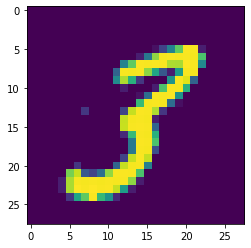

In [740]:
plt.imshow(x_2[0].squeeze(0).numpy())

In [759]:
def gsm(x, dim=-1):
    return torch.nn.functional.gumbel_softmax(x, hard=True, dim=dim)

In [760]:
b

tensor([[ 0., 10.,  3.],
        [ 1., -2.,  2.]])

In [761]:
gsm(b)

tensor([[0., 1., 0.],
        [0., 0., 1.]])

In [762]:
gsm(b,dim=0)

tensor([[0., 1., 1.],
        [1., 0., 0.]])

In [ ]:
nn.ReLU()

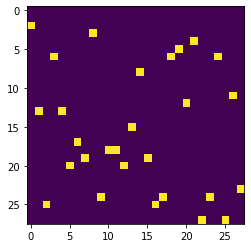

In [767]:
out = gsm(x_2[0].squeeze(0), dim=0)

plt.imshow(out)

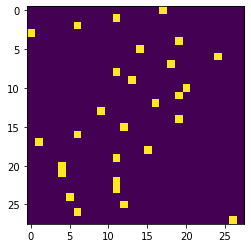

In [768]:
out = gsm(x_2[0].squeeze(0), dim=1)

plt.imshow(out)

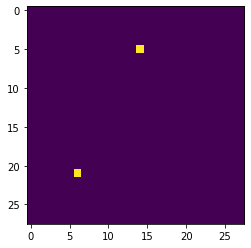

In [770]:
out_0 = gsm(x_2[0].squeeze(0), dim=0)
out_1 = gsm(x_2[0].squeeze(0), dim=1)
plt.imshow(out_0 * out_1)

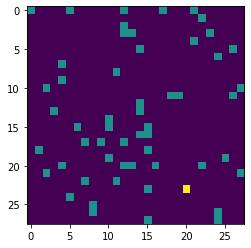

In [771]:
out_0 = gsm(x_2[0].squeeze(0), dim=0)
out_1 = gsm(x_2[0].squeeze(0), dim=1)
plt.imshow(out_0 + out_1)

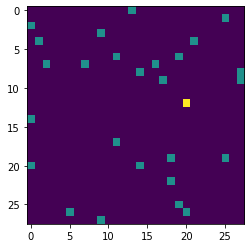

In [772]:
out_0 = gsm(x_2[0].squeeze(0), dim=0)
out_1 = gsm(x_2[0].squeeze(0), dim=1)
plt.imshow(out_0 @  out_1)

In [ ]:
torch.nn.functional.gumbel_softmax()

In [757]:
gsm(x_2.squeeze(0))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.]]]])

In [ ]:
# this seems relevant but how?
# a.scatter_()

In [ ]:
# torch.matmul() maybe be a good substitute

##### Port these layers onto a nn.Module

In [413]:
([p.shape for p in layer_single.parameters()], '\n',
[p.grad.shape for p in layer_single.parameters()])

([torch.Size([2, 24]), torch.Size([2])],
 '\n',
 [torch.Size([2, 24]), torch.Size([2])])

In [ ]:
class NeroNet(torch.nn.Module):
    def __init__(self, ):
        

###### Examine the structure of resnet18 and how it uses pooling

In [269]:
learn = cnn_learner(dl_1_topleft, resnet18, pretrained=True, 
                    y_range=(-1.,1.),)

x_3c, y_3c = dl_2.one_batch()

x_3c.shape

torch.Size([64, 3, 28, 28])

In [270]:
net_3c = learn.model

out = net_3c(x_3c)

out.shape

torch.Size([64, 2])

In [288]:
m_stage1 = learn.model[0][:3]
print(m_stage1)
print('------------')

m_pool1 = learn.model[0][3]
print(m_pool1)

x_00 = x_3c.clone()

x_01 = m_stage1(x_00) 
x_02 = m_pool1(x_01)

x_00.shape, x_01.shape, x_02.shape

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


(torch.Size([64, 3, 28, 28]),
 torch.Size([64, 64, 14, 14]),
 torch.Size([64, 64, 7, 7]))

In [339]:
# By changing the stride we can change the size the pool reduces to:
import copy
m_pool_s1 = copy.deepcopy(m_pool1)
m_pool_s1.stride = 1
print(m_pool_s1)

out = m_pool_s1(x_01)
out.shape

MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)


torch.Size([64, 64, 14, 14])

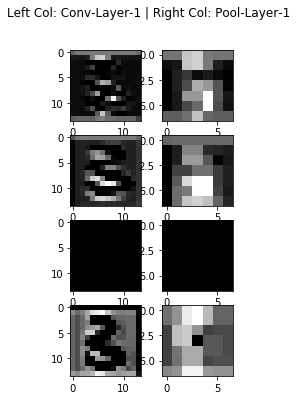

In [341]:
nrows = 4
fig, ax = plt.subplots(nrows, 2, figsize=(3,6))

for i in range(4):
#     ax[i][0].imshow(x_00[0,i,:,:].detach().numpy(), cmap='gray')
    ax[i][0].imshow(x_01[0,i,:,:].detach().numpy(), cmap='gray')
    ax[i][1].imshow(x_02[0,i,:,:].detach().numpy(), cmap='gray')

plt.suptitle('Left Col: Conv-Layer-1 | Right Col: Pool-Layer-1');

In [342]:
# ppol layer does work on a single image, instead a batch
out = m_pool1(x_01[0])

out.shape, out.grad_fn

(torch.Size([64, 7, 7]), <MaxPool2DWithIndicesBackward at 0x7fe7dbfc2210>)

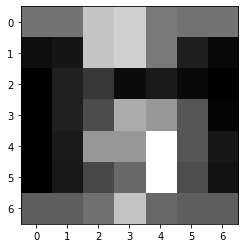

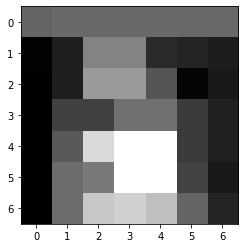

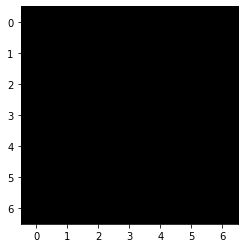

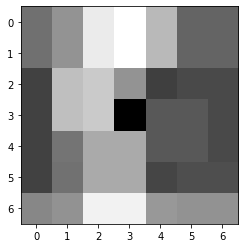

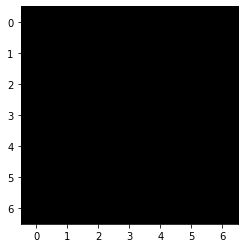

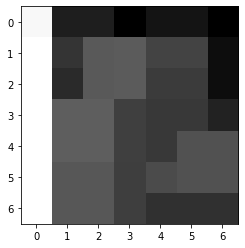

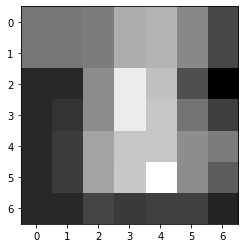

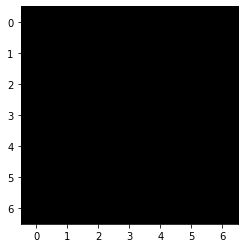

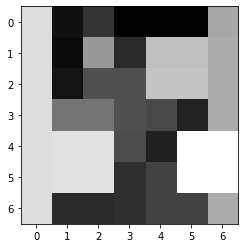

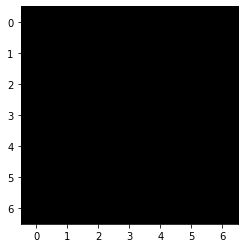

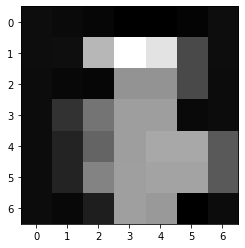

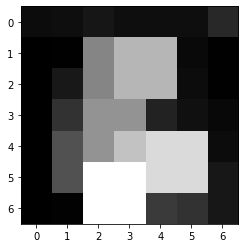

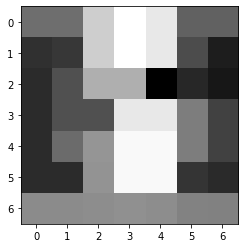

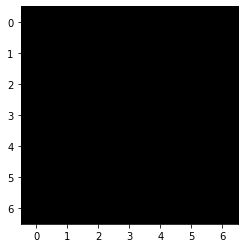

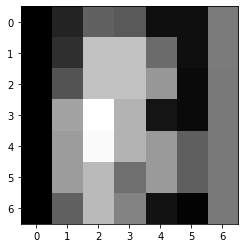

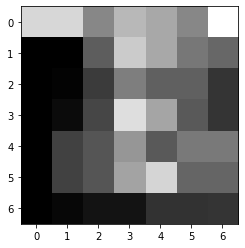

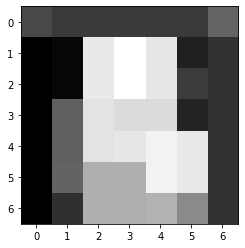

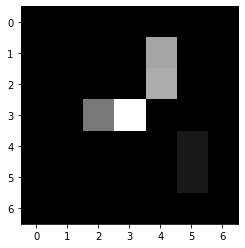

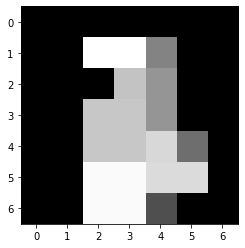

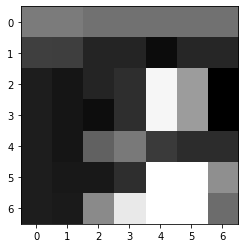

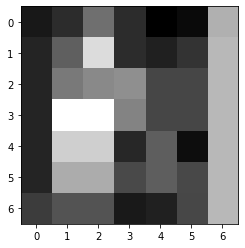

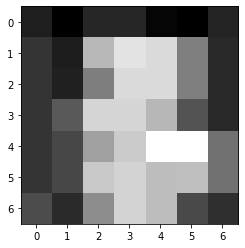

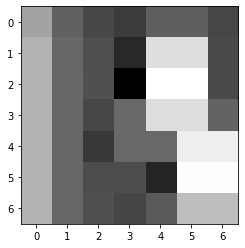

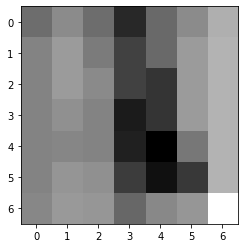

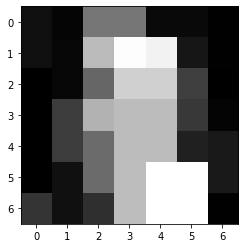

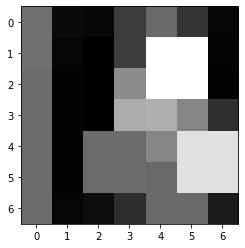

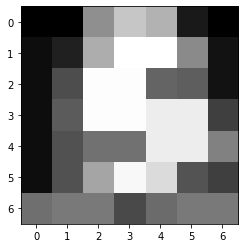

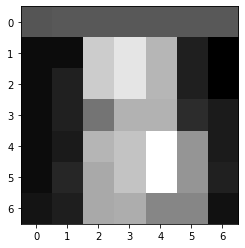

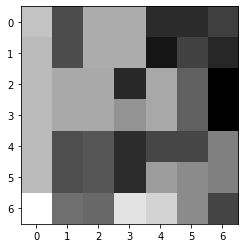

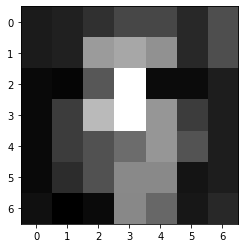

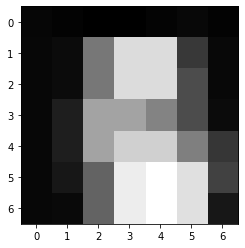

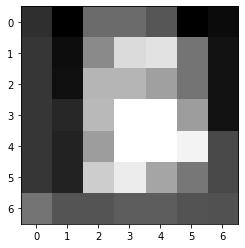

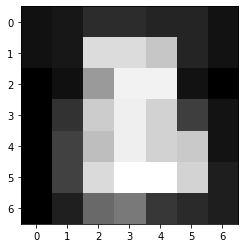

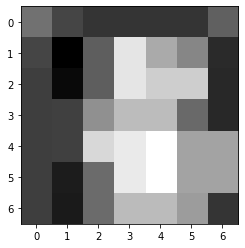

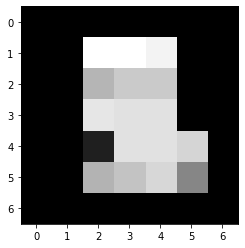

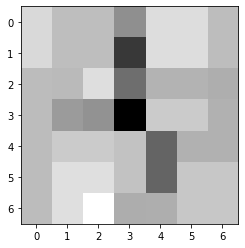

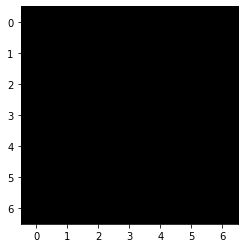

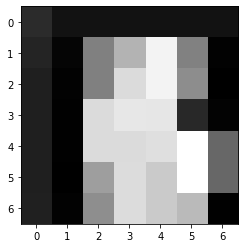

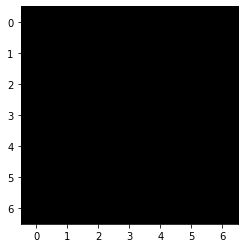

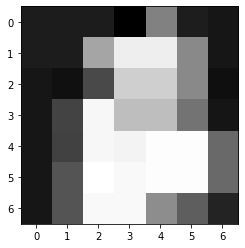

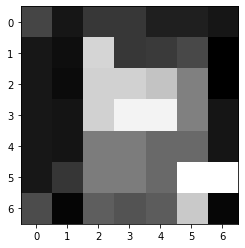

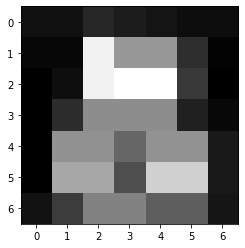

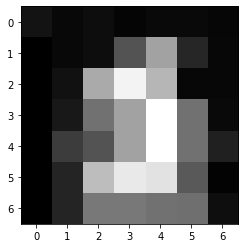

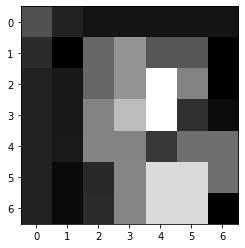

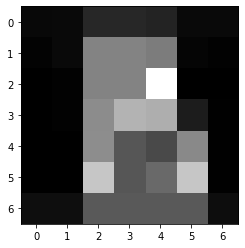

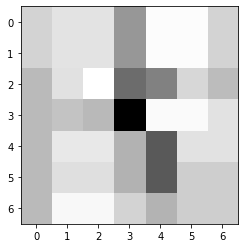

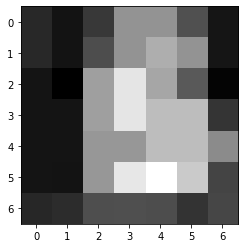

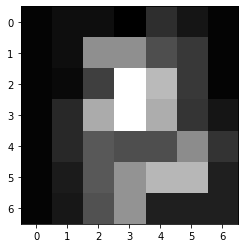

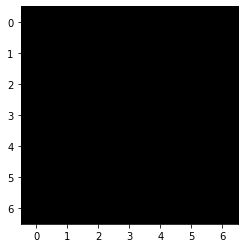

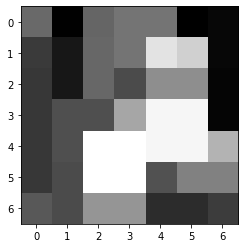

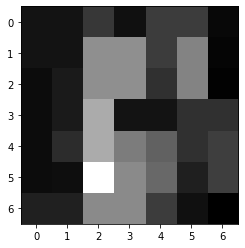

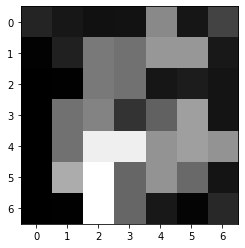

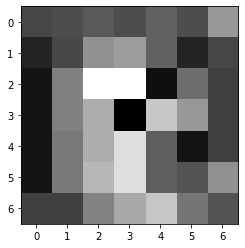

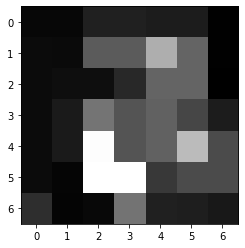

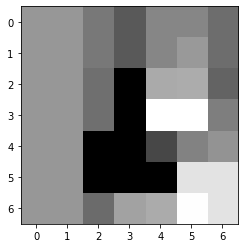

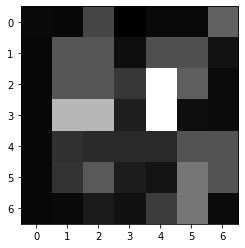

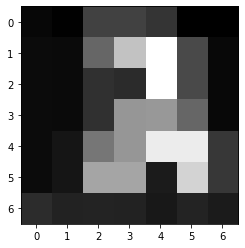

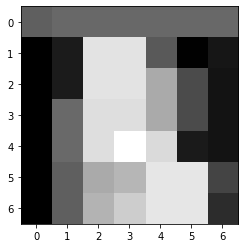

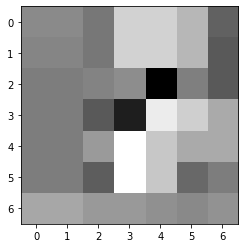

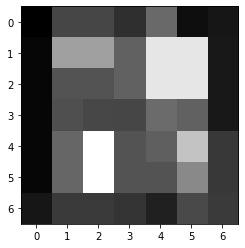

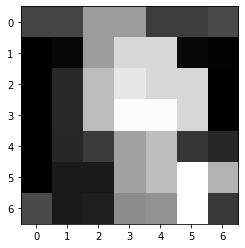

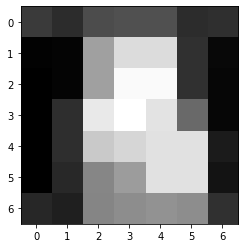

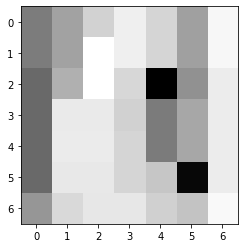

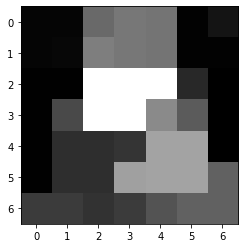

In [310]:
## Look at all the outputs of PoolLayer1
for i in range(64):
    plt.imshow(out[i].detach().numpy(), cmap='gray')
    plt.show()

In [370]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  